In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from mpi4py import MPI
from lammps import lammps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
#from lammps import pylammps

dI/dx=-aI-bI*I


I(x)=-a/b*exp(a/b*C)/(exp(a/b*C)-exp(ax))
a from here
https://www.pveducation.org/pvcdrom/materials/optical-properties-of-silicon

b is from here
https://aip.scitation.org/doi/full/10.1063/1.2737359
from border cond I(0)=I0:
C=1/a*ln(I0/(I0*b+a))
Fluence in J/cm2
wavelength in nm
pulselength in fs
porosity in %
zmax in nm

In [2]:
abs1=pd.read_csv('silicon_1photon_extinction.txt', sep='\t') #cm-1
abs2=pd.read_csv('silicon_2photon_absorbance.txt', sep=' ') #cm/GW
heatcapacity=0.7 #(J/(g*K))
density=2.3 #(g/cm3)
def get1phabsorbance(wavelength, data):
    return np.interp(wavelength, data['wavelength(nm)'], data['a(/cm)'])
def get2phabsorbance(wavelength, data):
    # in cm/W
    return np.interp(wavelength, data['wavelength(nm)'], data['b(cm/GW)'])/1000000
def calculate_tempdistr(wavelength, fluence, pulselength, porosity, zmax):
    T=[]
    I0=fluence/(pulselength/10**15)
    a=get1phabsorbance(wavelength, abs1)*(1-porosity)
    b=get2phabsorbance(wavelength, abs2)/100000000000
    C=1/a*np.log(I0/(I0*b+a))
    for i in range(zmax):
        I=-a*np.exp(a*C)/(b*np.exp(a*C)-np.exp(a*i*10**-7))
        Iabs=a*I+b*I*I
        T.append(Iabs*(pulselength/10**15)/(density*(1-porosity))/heatcapacity)
        #T.append(Iabs*(pulselength/10**15))
    return T


def run(A):
    return 'run ' + str(A)

def createinputelectrontemp(filename ,nx,ny,nz,T0):
    x_ = np.linspace(0., nx-1., nx)
    y_ = np.linspace(0., ny-1., ny)
    z_ = np.linspace(0., nz-1., nz)
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    x=x.astype(int) 
    y=y.astype(int)
    z=z.astype(int)
    hdl2=open('inputstemp/'+filename,'w+')
    for obj in zip(x.flatten(),y.flatten(),z.flatten()):
        T=float(T0*np.exp(-obj[2]))
        hdl2.write(str(obj[0])+' '+str(obj[1])+' '+str(obj[2])+' '+str(T)+'\n')
    hdl2.close()
    return 0
def calculate_heatstring(wavelength, fluence, pulselength, porosity, zmax):
    I0=fluence/(pulselength/10**15)
    a=get1phabsorbance(wavelength, abs1)
    b=get2phabsorbance(wavelength, abs2)
    C=1/a*np.log(I0/(I0*b+a))
    I='('+str(-a*np.exp(a*C))+'/'+'('+str(b*np.exp(a*C))+'-'+ 'exp({})'.format(str(a*10**(-7))+'*(5.43*{Size}-z)').format(Size=zmax)+')'+')'
    Heatsource='('+str(a)+'*'+I+'+'+str(b)+'*'+I+'*'+I+')'
    return Heatsource

In [3]:
C_e=0.00144
rho_e = 0.781
kappa_e = 0
gamma_p = 0.277 
gamma_s = 0.2191
v_0 = 0.0590
Nx = 10
Ny = 10
Nz = 10
N = 50

In [4]:
def getscript( wavelength, fluence, pulselength,porosity,zmax, size, center, radius,inputfilename='', porepos='sphere'):
    Cylindertop = 50
    Cylinderbottom = 0
    filename= inputfilename
    fluxfilename='NPs_{porepos}_flux_output{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize'.format(porepos=porepos,wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    moviename ='3d_{porepos}_{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(porepos=porepos,wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    flatmoviename='flat_{porepos}_{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(porepos=porepos,wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    slicemoviename='slice_{porepos}_{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(porepos=porepos,wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    flatslicemoviename='flatslice_{porepos}_{wavelength}nm{fluence}Jcm2{pulselength}fs{porosity}por{size}nmsize.mpg'.format(porepos=porepos,wavelength=wavelength,
    fluence=fluence, pulselength=pulselength, porosity=porosity,size=size)
    desiredtemp=calculate_tempdistr(wavelength, fluence, pulselength, porosity, zmax)
    #INIT
    Initialize='''
    units metal
    atom_style atomic
    atom_modify map array
    dimension       3
    boundary        p p f
    '''
    #DEFINE REGIONS
    #region 3 cylinder z {Center} {Center} {Radius} {Cylinderbottom} {Cylindertop} units lattice 
    Regions=''' 
    lattice  diamond 5.43
    region 1 block 0 {Size} 0 {Size} 1 50 units lattice
    region 3 block 0 {Size} 0 {Size} 1 50 units lattice
    region centerslice block {slicex1} {slicex2} 0 {Size} 1 100 units lattice
    region todump block 0 {Size} 0 {Size} 51 100 units lattice
    
    '''.format(Size=size, Center=center, Radius=radius, 
               Cylinderbottom=Cylinderbottom, Cylindertop=Cylindertop,slicex1=size//2-2, slicex2=size//2)
    Regionslayers=''.join(['''
    region l{i} block 0 {Size} 0 {Size} {ans} {ans2} units lattice
    '''.format(i=i, ans=50-i,ans2=50-i+3, Size=50) for i in range (2,50,2)])
    
    #CREATE ATOMS
    Atomcreation=''' 
        create_atoms 1 region 1
        '''
    #OR LOAD THEM FROM FILE
    Atomreading=''' 
        read_data {filename}
        '''.format(filename=filename)
    #ATOM GROUPS AND PARAMS
    Atomconfig=''' 
    group allatoms type 1
    group centeratoms1 region 3
    variable Nn equal count(all,todump)
    mass 1 28.0
    pair_style tersoff 
    pair_coeff * * Si.tersoff  Si
    neighbor 0.5 bin
    neigh_modify every 1 delay 1 check yes 
    '''
    #layered atom groups
    layeredgroups=''.join(['''
    group layeratoms{i} region l{i}
    '''.format(i=i) for i in range (2,50,2)])
    
    #CALC CONFIG
    Calcconf=''' 
    thermo 10
    thermo_modify lost ignore flush yes
    velocity allatoms create 300 12345
    fix 2 all nve
    fix 3 all ave/time 1 1 1 v_Nn file {fluxfilename}
    compute coord all coord/atom cutoff 2.6
    '''.format(fluxfilename='outputs/'+fluxfilename)
    
    #DUMP CONFIG
    
    Dumpoptions=''' 
    dump  8  all  movie  2  {moviename}  c_coord  type  zoom  1.0  adiam  2.2  axes  yes  0.8  0.02  view  60  -30  size  2048  2048
    dump  9  all  movie  2  {flatmoviename}  c_coord  type  zoom  1.6  adiam  2.2  axes  yes  0.8  0.02  view  90  0  size  2048  2048
    dump  12  all  movie  2 {slicemoviename}  c_coord  type  zoom  1.0  adiam  2.2  axes  yes  0.8  0.02  view  60  -30  size  2048  2048
    dump  13  all  movie  2 {flatslicemoviename}  c_coord  type  zoom  1.6  adiam  2.2  axes  yes  0.8  0.02  view  90  0  size  2048  2048

    dump_modify 8 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green
    dump_modify 9 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green
    dump_modify 12 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green region centerslice
    dump_modify 13 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green region centerslice
    '''.format(moviename='outputs/'+moviename,flatmoviename='outputs/'+flatmoviename,
               slicemoviename='outputs/'+slicemoviename,flatslicemoviename='outputs/'+flatslicemoviename)
    Dumpoptions2=''' 
    dump  13  all  movie  2 {flatslicemoviename}  c_coord  type  zoom  1.6  adiam  2.2  axes  yes  0.8  0.02  view  90  0  size  2048  2048
    dump_modify 13 amap 1 6 cf 0.0 3 min blue 0.6 yellow max green region centerslice
    '''.format(moviename='outputs/'+moviename,flatmoviename='outputs/'+flatmoviename,
               slicemoviename='outputs/'+slicemoviename,flatslicemoviename='outputs/'+flatslicemoviename)
    #CREATE PULSEVELOCITYDIST
    desiredtemps=calculate_tempdistr(wavelength, fluence, pulselength, porosity, zmax)
    #print(wavelength, fluence, pulselength, porosity, zmax)
    createpulse=''.join(['''
    fix {j} layeratoms{i} temp/rescale 1 {desiredtemp} {desiredtemp} 0.05 1.0
    '''.format(i=i,j=i+100,desiredtemp=int(desiredtemps[i-2]))for i in range (2,50,2)])
    #print(desiredtemp)
    #REMOVE PULSE
    unfixtemps=''.join(['''
    unfix {j}
    '''.format(j=i+100) for i in range (2,50,2)])
    #createpulse=''' 
    #velocity centeratoms1 create 1 12345
    #variable vxprof atom vx*sqrt({temp})
    #variable vyprof atom vy*sqrt({temp})
    #variable vzprof atom vz*sqrt({temp})
    #velocity centeratoms1 set v_vxprof v_vyprof v_vzprof
    #'''.format(temp=calculate_tempdistrstring(wavelength, fluence, pulselength, porosity, zmax))
    #CREATE SCRIPT
    script=(Initialize+Regions+Regionslayers+Atomreading+layeredgroups+Atomconfig +Calcconf +
    run(100)+createpulse+run(3)+unfixtemps+run(1000))
    return script

In [7]:
desiredtemps=calculate_tempdistr(wavelength=300, fluence=1, pulselength=1000, porosity=0.5, zmax=50)
#calculate_tempdistr(wavelength=300, fluence=1, pulselength=pulselength, porosity=porosity, zmax=zmax)

(0, 56374.28175521086)

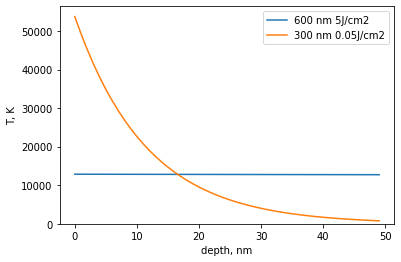

In [15]:
for pulselength in [1000000000000000]:
    desiredtemp=calculate_tempdistr(wavelength=600, fluence=5, pulselength=pulselength, porosity=0.5, zmax=50)
    plt.plot([a for a in desiredtemp],label='600 nm 5J/cm2')
for pulselength in [1000000000000000]:
    desiredtemp=calculate_tempdistr(wavelength=300, fluence=0.05, pulselength=pulselength, porosity=0.5, zmax=50)
    plt.plot([a for a in desiredtemp],label='300 nm 0.05J/cm2')
plt.legend()
plt.xlabel('depth, nm')
plt.ylabel('T, K')
plt.ylim(0)

In [10]:
for porosity in [0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    desiredtemp=calculate_tempdistr(wavelength=300, fluence=1, pulselength=pulselength, porosity=porosity, zmax=50)
    plt.plot([np.log10(a) for a in desiredtemp], label=str(porosity))
plt.legend()

NameError: name 'pulselength' is not defined

In [13]:
'''script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename)
hdl=open('torun/script_{}nm_{}Jcm2_{}fs_{}_por'.format(wavelength, fluence, pulselength, porosity),'w')
hdl.write(script)
hdl.close()'''

In [2]:
inputfilename

'siliconmesopores0.0.csv'

In [5]:
#porepos='sphere'
#inputfilename='Si_1010100.csv'
#inputfilename='microporSi50percent_1010100.csv'
inputfilename='Si_1010100.csv'
runscriptstring=[]
wavelength=600
porosity=0.0
zmax=50
Size = 10
Center = 5.0
Radius = 2.0
fluence=1
pulselength=10 #fs
torun=''
for porepos in['1_2nmpores']:
    #for porosity in [0.5,0.8,0.0]:
    for porosity in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        if porepos=='1_2nmpores':
            inputfilename='silicon1_2nmpores{}.csv'.format(porosity)
        if porepos=='1_6nmpores':
            inputfilename='silicon1_6nmpores{}.csv'.format(porosity)
        if porepos=='1_8nmpores':
            inputfilename='silicon1_8nmpores{}.csv'.format(porosity)
        if porepos=='2_5nmpores':
            inputfilename='silicon2_5nmpores{}.csv'.format(porosity)
        if porepos=='3nmpores':
            inputfilename='silicon3nmpores{}.csv'.format(porosity)
        if porepos=='2nmpores':
            inputfilename='silicon2nmpores{}.csv'.format(porosity)
        if porepos=='mesosphere':
            inputfilename='siliconmesopores{}.csv'.format(porosity)
        if porepos=='sphere':
            inputfilename='siliconpores{}.csv'.format(porosity)
        if porepos=='hor':
            inputfilename='siliconhorizontalpores{}.csv'.format(porosity)
        if porepos=='vert':
            inputfilename='siliconverticalpores{}.csv'.format(porosity)
        for fluence in [0.001, 0.005,0.009]:
            for wavelength in [300]:
                for pulselength in [1000]:
                    #for fluence in 
                    script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename,porepos=porepos)
                    hdl=open('torun/script_{}nm_{}Jcm2_{}fs_{}_{}'.format(wavelength, "{0:.4f}".format(fluence), pulselength, porosity,porepos),'w')
                    hdl.write(script)
                    hdl.close()
                    torun=torun+('mpirun -np 3 lmp_mpi -in script_{}nm_{}Jcm2_{}fs_{}_{}'.format(wavelength, "{0:.4f}".format(fluence), pulselength, porosity,porepos) + '\n')

In [6]:
hdl=open('torun/allscripts.sh','w')
hdl.write(torun)
hdl.close()

In [9]:
#inputfilename='Si_1010100.csv'
for wavelength in [300,400,500,600,700,800,900,1000]:
    for pulselength in [10,20,40,100]:#,200,400,1000,2000,4000,10000, 20000,40000,100000, 200000,400000,1000000]:
        #lmp = lammps()
        print(wavelength,pulselength)
        script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename)
        for line in script.split('\n'):
            lmp.command(line)
inputfilename='Si_1010100.csv'
porosity=0
for wavelength in [300,400,500,600,700,800,900,1000]:
    for pulselength in [10,20,40,100]:#,200,400,1000,2000,4000,10000, 20000,40000,100000, 200000,400000,1000000]:
        hdl=open('torun/script_{}nm_{}Jcm2_{}fs_{}_por'.format(wavelength, fluence, pulselength, porosity),'w')
        lmp = lammps()
        print(wavelength,pulselength)
        script=getscript(wavelength, fluence, pulselength, porosity,zmax, Size, Center, Radius,inputfilename)
        for line in script.split('\n'):
            hdl.write(script)
            hdl.close()
            lmp.command(line)

300 10


NameError: name 'lmp' is not defined

In [7]:
#from mpi4py import MPI
#comm = MPI.COMM_WORLD
#print ("Proc %d out of %d procs" % (comm.Get_rank(),comm.Get_size()))

In [38]:
x1=[]
y1=[]
y2=[]
for k in range(300,1100, 10):
    x1.append(k)
    y1.append(get1phabsorbance(k,abs1))
    y2.append(get2phabsorbance(k,abs2))
#plt.plot(x1,y1)
plt.plot(x1,y2)

In [61]:
%matplotlib auto
Xsez=[]
Ysez=[]
Zsez=[]
c=[]
for filename in ['outputs/'+file for file in os.listdir('outputs') if file.startswith('NPs_')]:
    try:
        flux=pd.read_csv(filename,sep=' ', header=2).iloc[800]['0.1']
        wavelength=float(filename.split('output')[-1].split('nm')[-3])
        fluence=float(filename.split('J')[-2].split('nm')[-1])
        pulselength=float(filename.split('fs')[-2].split('cm2')[-1])
        porous=float(filename.split('por')[-2].split('fs')[-1])
        
        if pulselength>0:
            if wavelength>0 and porous<0.1:
                Xsez.append(pulselength)#np.log(pulselength))
                Ysez.append(wavelength)
                Zsez.append(flux)
                c.append(porous)
    except:
        None
    #print(flux,wavelength,pulselength)


fig = plt.figure()
ax = Axes3D(fig) 
#ax.scatter(np.log(Xsez),Ysez,Zsez, c=c)
ax.plot_trisurf(np.log(Xsez),Ysez,Zsez)
#ax = Axes3D(fig) 
#ax.scatter(np.array(Xsez), np.array(Ysez), np.array(Zsez), 1, cmap='viridis', edgecolor='none')
#ax.set_title('surface');

Using matplotlib backend: Qt5Agg


In [55]:
A=list(set(np.log(Xsez)))
A.sort()
A=np.array(A)
B=list(set(Ysez))
B.sort()
B=np.array(B)

In [ ]:
x_ = np.linspace(0., nx-1., nx)
y_ = np.linspace(0., ny-1., ny)
z_ = np.linspace(0., nz-1., nz)
x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
x=x.astype(int)
y=y.astype(int)
z=z.astype(int)
    #hdl2=open('inputstemp/'+filename,'w+')
for obj in zip(x.flatten(),y.flatten(),z.flatten()):
    #T=T0*np.exp(-z)
    #hdl2.write(str(obj[0])+str(obj[1])+str(obj[2])+str(T)+'\n')
    A=0

In [ ]:
#createinputelectrontemp('testelectgronfile.txt', 10,10,10,10000)

In [ ]:
wavelength=300
fluence=0.1
createscript('in.porousfalse_{}nm{}Jcm2'.format(wavelength,fluence), size=100, porous=True, fluence=fluence, alpha=get1phabsorbance(wavelength, abs1), beta=get2phabsorbance(wavelength, abs2))

In [ ]:
get1phabsorbance(400, abs1)

In [ ]:
for scriptname in os.listdir('scripts'):
    print ('CALL lmp_serial -in {} -pk omp 4 -sf omp'.format(scriptname))

In [ ]:
plt.plot(calculate_tempdistr(300, 0.1, 1000000, 0.1, 100))